In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df= pd.read_csv('/Users/burakfindikli/Documents/Mackolik/data/2018-2019_tsl.csv',index_col = False)
df2=pd.read_csv('/Users/burakfindikli/Documents/Mackolik/data/2017-2018_tsl.csv',index_col = False)

In [48]:
#  2017-2018 ile 2018-2019 sezonunun Maçlarını birleştirdim
df3=pd.concat([df, df2], ignore_index=True)


In [49]:
#Maçı ev sahibi kazandıysa 1 beraberlik olduysa 0 deplasman takımı kazandıysa 2 diye kodladım.
df3["kazanan_dep"]=df3.ev_sonuc < df3.dep_sonuc
df3.kazanan_dep = df3.kazanan_dep.astype(int)*2

df3["kazanan_ev"] = df3.ev_sonuc > df3.dep_sonuc
df3.kazanan_ev = df3.kazanan_ev.astype(int)

df3["kazanan_berabere"] = df3.ev_sonuc == df3.dep_sonuc
df3.kazanan_berabere = df3.kazanan_berabere.astype(int)*0

df3["sonuc"]=df3.kazanan_dep+df3.kazanan_ev+df3.kazanan_berabere
df3=df3.drop(['kazanan_dep', 'kazanan_ev','kazanan_berabere','ev_gol','dep_gol'], axis=1)
del(df,df2)

In [50]:
#bu değişkenlerde % ve , var temizleme yapmam lazım
col=['ev_topla_oynama','ev_ikili_mucadele_kazanma','ev_hava_topu','dep_topla_oynama','dep_ikili_mucadele_kazanma','dep_hava_topu','ev_pas_isabet','ev_rakip_yari_sahada_pas_isabeti','ev_orta_istabeti','dep_pas_isabet','dep_rakip_yari_sahada_pas_isabeti','dep_orta_istabeti','ev_sut_isabeti','dep_sut_isabeti','ev_top_kapma_basarisi','dep_top_kapma_basarisi']

In [51]:
# col değişkenindeki % , gibi karakterleri replace ettim
k=0
while k < df3[col].shape[1]:
    df3[col[k]] = df3[col[k]].str.replace(",",".")
    df3[col[k]] = df3[col[k]].str.replace("%","")
    k+=1

In [52]:
#object olan veri tiplerini floata çevirdim
df3[col]=df3[col].astype(float)

In [53]:
drop_value = ['ev_takim', 'dep_takim', 'ev_sonuc', 'dep_sonuc', ]
df3=df3.drop(drop_value,axis=1)

In [54]:
from sklearn.model_selection import train_test_split

In [55]:
#bağımlı bağımsız değişkenlerimi ayırdım 
#bağımlı değişken sonuc(1=Evsahibi kazanır 0=Beraberlik 2=Deplasman kazanır)
x = df3.iloc[:,:-1]
y = df3.sonuc
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
x_scaled = stdsc.fit_transform(x)
X_train, X_test, y_train, y_test = train_test_split(x_scaled,y,test_size=0.2)

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import time

In [57]:
start = time.process_time()
model = RandomForestClassifier(n_estimators=700).fit(X_train,y_train)
print(time.process_time()-start)

3.355553999999998


In [58]:
preds = model.predict(X_test)

In [59]:
print(confusion_matrix(y_test,preds))

[[ 30  30   7]
 [  4 135  10]
 [  5  18  58]]


In [60]:
model.score(X_test,y_test)

0.7508417508417509

In [61]:
model.feature_importances_

array([0.02106986, 0.0197952 , 0.01944851, 0.01610385, 0.01205725,
       0.01359844, 0.01988106, 0.02085364, 0.01981501, 0.0175068 ,
       0.0113476 , 0.01300472, 0.02110286, 0.01756887, 0.02324643,
       0.02499319, 0.03383007, 0.0215433 , 0.02659021, 0.02290578,
       0.02681548, 0.02478158, 0.02215118, 0.02119544, 0.01692429,
       0.03625427, 0.0123253 , 0.01533064, 0.02423794, 0.05422843,
       0.01875048, 0.03621246, 0.01021552, 0.01315109, 0.02473408,
       0.04058243, 0.01605149, 0.01766734, 0.03180434, 0.01915941,
       0.01934905, 0.04119655, 0.01597896, 0.01064552, 0.00314466,
       0.01605504, 0.01091023, 0.00388414])

In [62]:
feature_imp = pd.Series(model.feature_importances_, index = x.columns)

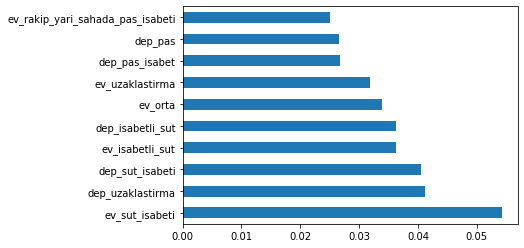

In [65]:
feature_imp.nlargest(10).plot(kind='barh')

In [91]:
best_feature = feature_imp.nlargest(6).index.to_list()

In [92]:
x_reduced = x[best_feature]

In [93]:
xr_scaled = StandardScaler().fit_transform(x_reduced)

In [94]:
Xr_train, Xr_test, yr_train, yr_test = train_test_split(xr_scaled,y,test_size=0.2)

In [95]:
start = time.process_time()
rmodel = RandomForestClassifier(n_estimators=700).fit(Xr_train,yr_train)
print(time.process_time()-start)

2.2059480000000065


In [96]:
rpred = rmodel.predict(Xr_test)
print(confusion_matrix(yr_test,rpred))
print(classification_report(yr_test,rpred))

[[ 32  32  10]
 [  7 119  13]
 [  9  16  59]]
              precision    recall  f1-score   support

           0       0.67      0.43      0.52        74
           1       0.71      0.86      0.78       139
           2       0.72      0.70      0.71        84

    accuracy                           0.71       297
   macro avg       0.70      0.66      0.67       297
weighted avg       0.70      0.71      0.70       297

